In [1]:
!date

Fri Jun 17 10:43:31 EDT 2022


In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from helper_funcs import *

In [4]:
analysis_name = 'CVAE_2022-03-25 18:28:49.469238'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

data = np.load(os.path.join(save_dir,'results.npz'))
data = dict(data)
data_keys = list(data.keys())

In [5]:
func_sl_all = data['S_sample100'][0,:,:]
func_bg_all = data['Z_sample100'][0,:,:]

In [6]:
dff = pd.read_csv('../Data/comb_df.csv')
dff.head()

,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset
0,0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I
1,2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I
2,3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I
3,4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I
4,9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I


In [7]:
def dummy_ordinal(invec):
    unique_values = np.unique(invec)
    new_values = np.arange(1,len(unique_values)+1)
    new_arr = [new_values[val==unique_values][0] for val in invec]
    return new_arr
dff['site_id'] = dummy_ordinal(dff['site'])

In [8]:
dfa = pd.read_csv('../../BC-CVAE-MRI-ASD-PUB/Data/ABIDE_legend_S982.csv')
anat_data = np.load('../../BC-CVAE-MRI-ASD-PUB/Data/latent_vecs10.npz')
anat_sl_all = anat_data['salient_vec_abide'][0,:,:]
anat_bg_all = anat_data['background_vec_abide'][0,:,:]
print(dfa.shape)
dfa.head()

(982, 90)


,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3


In [9]:
func_subs = dff.iloc[(dff['dataset'].values=='ABIDE I') * (dff['diag'].values==1)]['participant_id'].values
anat_subs = dfa['SubID'].values[dfa['DxGroup'].values==1]

In [10]:
assert len(np.unique(anat_subs))==len(anat_subs),'lol'
assert len(np.unique(func_subs))==len(func_subs),'lol'

In [11]:
unique_subs,counts = np.unique(np.hstack((func_subs,anat_subs)),return_counts=True)

In [12]:
common_subs = unique_subs[counts==2]

In [13]:
n = len(common_subs)

anat_bg = np.zeros((n,16))
anat_sl = np.zeros((n,16))
func_bg = np.zeros((n,16))
func_sl = np.zeros((n,16))

for s in range(n):
    subID = common_subs[s]
    anat_bg[s,:] = anat_bg_all[dfa['SubID'].values==subID,:]
    anat_sl[s,:] = anat_sl_all[dfa['SubID'].values==subID,:]
    func_bg[s,:] = func_bg_all[dff['participant_id'].values==subID,:]
    func_sl[s,:] = func_sl_all[dff['participant_id'].values==subID,:]

In [14]:
dfa.iloc[dfa['SubID'].values==subID]['FIQ']

27    118.0
Name: FIQ, dtype: float64

In [15]:
dff.iloc[dff['participant_id'].values==subID]

,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset,site_id
846,1046,51606,1,29.0,2,118.0,6,2.0,NaN,NaN,NaN,NaN,ABIDE I,17


In [16]:
dff_sorted = dff.iloc[[np.argwhere(dff['participant_id'].values==common_subs[i])[0][0] for i in range(n)]]
dfa_sorted = dfa.iloc[[np.argwhere(dfa['SubID'].values==common_subs[i])[0][0] for i in range(n)]]

In [17]:
def fit_rsa(rdm_data,rdm_model,measure='pearson',cov=None):
    from scipy.stats import kendalltau
    from pingouin import partial_corr
    
    if measure=='pearson':
        r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    elif measure=='kendall':
        r = kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif measure=='partial_kendall':
        arr = pd.DataFrame(np.array([get_triu(rdm_data),get_triu(rdm_model),get_triu(cov)]).transpose(),columns=['x','y','cv1'])
        r = partial_corr(data=arr, x='x', y='y', covar='cv1')['r'].values[0]
            
    return r

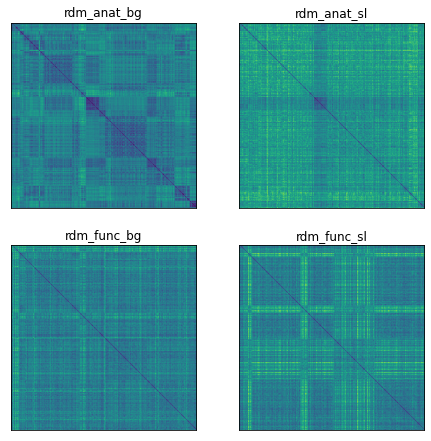

In [18]:
metric = 'correlation'
metric = 'euclidean'
rdm_anat_bg = make_RDM(anat_bg,metric=metric)
rdm_anat_sl = make_RDM(anat_sl,metric=metric)
rdm_func_bg = make_RDM(func_bg,metric=metric)
rdm_func_sl = make_RDM(func_sl,metric=metric)

plt.figure(figsize=np.array((5,5))*1.5)
plt.subplot(2,2,1)
plt.imshow(rdm_anat_bg);plt.xticks([]);plt.yticks([]);plt.title('rdm_anat_bg');
plt.subplot(2,2,2)
plt.imshow(rdm_anat_sl);plt.xticks([]);plt.yticks([]);plt.title('rdm_anat_sl');
plt.subplot(2,2,3)
plt.imshow(rdm_func_bg);plt.xticks([]);plt.yticks([]);plt.title('rdm_func_bg');
plt.subplot(2,2,4)
plt.imshow(rdm_func_sl);plt.xticks([]);plt.yticks([]);plt.title('rdm_func_sl');

/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<AxesSubplot:>

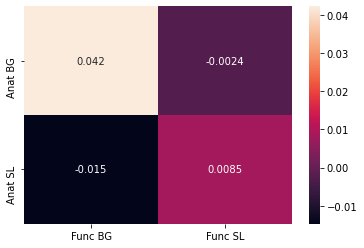

In [19]:
rsa_sim = np.zeros((2,2))
rsa_sim[0,0] = fit_rsa(rdm_anat_bg,rdm_func_bg,measure='kendall')
rsa_sim[0,1] = fit_rsa(rdm_anat_bg,rdm_func_sl,measure='kendall')
rsa_sim[1,0] = fit_rsa(rdm_anat_sl,rdm_func_bg,measure='kendall')
rsa_sim[1,1] = fit_rsa(rdm_anat_sl,rdm_func_sl,measure='kendall')
sns.heatmap(rsa_sim,annot=True,yticklabels=['Anat BG','Anat SL'],xticklabels=['Func BG','Func SL'])

In [20]:
rsa_sim[0,0]/rsa_sim[1,1]

4.973456987946695

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [22]:
nc = 5
cid_anat_bg = KMeans(n_clusters=nc).fit_predict(rdm_anat_bg)
cid_anat_sl = KMeans(n_clusters=nc).fit_predict(rdm_anat_sl)
cid_func_bg = KMeans(n_clusters=nc).fit_predict(rdm_func_bg)
cid_func_sl = KMeans(n_clusters=nc).fit_predict(rdm_func_sl)

In [23]:
cid_mat = np.zeros((2,2))
cid_mat[0,0] = adjusted_rand_score(cid_anat_bg,cid_func_bg)
cid_mat[0,1] = adjusted_rand_score(cid_anat_bg,cid_func_sl)
cid_mat[1,0] = adjusted_rand_score(cid_anat_sl,cid_func_bg)
cid_mat[1,1] = adjusted_rand_score(cid_anat_sl,cid_func_sl)

<AxesSubplot:>

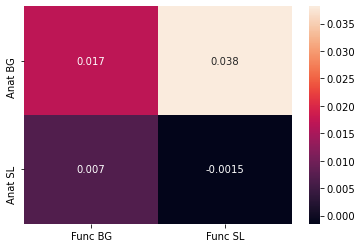

In [24]:
sns.heatmap(cid_mat,annot=True,yticklabels=['Anat BG','Anat SL'],xticklabels=['Func BG','Func SL'])

In [25]:
from sklearn.decomposition import PCA

In [26]:
pc_anat_bg = PCA(n_components=1).fit_transform(rdm_anat_bg)[:,-1]
pc_anat_sl = PCA(n_components=1).fit_transform(rdm_anat_sl)[:,-1]
pc_func_bg = PCA(n_components=1).fit_transform(rdm_func_bg)[:,-1]
pc_func_sl = PCA(n_components=1).fit_transform(rdm_func_sl)[:,-1]

In [27]:
np.corrcoef(pc_anat_bg,pc_func_bg)[0,1]

0.033287807591923166

In [28]:
np.corrcoef(pc_anat_sl,pc_func_sl)[0,1]

0.017523423617664274

In [29]:
def key_rsa_partial(inMat,key,model_scale,df_use,return_models=False,cov=None):
    vec = df_use[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    if type(cov)==type(None):
        cov_rdm = make_RDM(df_use['site_id'].values[~e],data_scale='ordinal', metric='euclidean')
    else:
        cov_rdm = make_RDM(cov[~e])
        
    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='partial_kendall',cov=cov_rdm) for i in range(10)])
        

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [30]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_total',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_total',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=anat_sl)[0][0])

0.026780055508685653
0.026758110012783772


In [31]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_social',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_social',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=anat_sl)[0][0])

0.03567478916364629
0.0351715694411074


In [32]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_comm',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_comm',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=anat_sl)[0][0])

-0.010818834060774551
-0.008122863266453496


In [33]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_rrb',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_rrb',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=anat_sl)[0][0])

0.08482534704096321
0.0850807507500286


In [34]:
v1 = {'label' : 'anat_sl', 'data' : anat_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_total',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_total',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_sl)[0][0])

0.016882661879019878
0.016854480809677014


In [35]:
v1 = {'label' : 'anat_sl', 'data' : anat_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_social',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_social',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_sl)[0][0])

0.007976133411325585
0.007553804961402186


In [36]:
v1 = {'label' : 'anat_sl', 'data' : anat_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_comm',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_comm',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_sl)[0][0])

0.03563144766312067
0.038498638504417315


In [37]:
v1 = {'label' : 'anat_sl', 'data' : anat_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_rrb',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_rrb',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_sl)[0][0])

-0.04374565923363139
-0.03881973688882376


In [38]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_total',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_total',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_bg)[0][0])

0.026780055508685653
0.032462804176054155


In [39]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_social',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_social',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_bg)[0][0])

0.03567478916364629
0.04084937223882576


In [40]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_comm',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_comm',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_bg)[0][0])

-0.010818834060774551
-0.004807307042775499


In [41]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='ados_rrb',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='ados_rrb',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_bg)[0][0])

0.08482534704096321
0.08418148725013833


In [42]:
v1 = {'label' : 'func_sl', 'data' : func_sl, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1]
print(key_rsa_partial(inMat=inMat,key='DSMIV',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=None)[0][0])
print(key_rsa_partial(inMat=inMat,key='DSMIV',model_scale='ratio',df_use=dff_sorted,return_models=False,cov=func_bg)[0][0])

0.11380218623026267
0.12226319797309823


In [43]:
dff_sorted.columns

Index(['Unnamed: 0', 'participant_id', 'diag', 'age', 'sex', 'fiq', 'site',
       'DSMIV', 'ados_total', 'ados_social', 'ados_comm', 'ados_rrb',
       'dataset', 'site_id'],
      dtype='object')